In [9]:
# 1. Imports and Setup
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from fpdf import FPDF
import os

# Configure
api_key = "38ae73f3e16148fabfb768800ad3c8dd"  # Replace with your actual Twelve Data API key
symbols = ["AAPL", "MSFT", "GOOGL", "AMZN", "META"]
start_date = "2020-01-01"
interval = "1day"

# Folder Setup
os.makedirs("plots", exist_ok=True)
os.makedirs("data", exist_ok=True)

In [10]:
# 2. Function to Get Data from Twelve Data
def fetch_twelve_data(symbol, api_key):
    url = f"https://api.twelvedata.com/time_series"
    params = {
        "symbol": symbol,
        "interval": interval,
        "start_date": start_date,
        "apikey": api_key,
        "outputsize": 5000,
        "format": "JSON"
    }

    response = requests.get(url, params=params)
    data = response.json()
    
    if "values" not in data:
        print(f"⚠️ Failed for {symbol}: {data.get('message', 'Unknown error')}")
        return None

    df = pd.DataFrame(data["values"])
    df["datetime"] = pd.to_datetime(df["datetime"])
    df.set_index("datetime", inplace=True)
    df = df.sort_index()
    df = df.astype(float)
    df.rename(columns={"close": "Close"}, inplace=True)
    
    return df

In [11]:
# 3. Fetch & Save CSVs for Each Stock
stock_data = {}

for symbol in symbols:
    print(f"📈 Fetching: {symbol}")
    df = fetch_twelve_data(symbol, api_key)
    if df is not None:
        stock_data[symbol] = df
        df.to_csv(f"data/{symbol}_historical.csv")

📈 Fetching: AAPL
📈 Fetching: MSFT
📈 Fetching: GOOGL
📈 Fetching: AMZN
📈 Fetching: META


In [12]:
# 4. Mean Reversion Strategy (Bollinger + Z-score)
def apply_strategy(df, window=20, z_entry=1.0, z_exit=0.5):
    df = df.copy()
    df["mean"] = df["Close"].rolling(window=window).mean()
    df["std"] = df["Close"].rolling(window=window).std()
    df["z_score"] = (df["Close"] - df["mean"]) / df["std"]
    
    df["signal"] = 0
    df.loc[df["z_score"] > z_entry, "signal"] = -1  # Sell
    df.loc[df["z_score"] < -z_entry, "signal"] = 1  # Buy
    df.loc[abs(df["z_score"]) < z_exit, "signal"] = 0  # Exit
    
    df["position"] = df["signal"].shift()
    df["returns"] = df["Close"].pct_change()
    df["strategy_returns"] = df["position"] * df["returns"]
    df["cumulative"] = (1 + df["strategy_returns"]).cumprod()
    
    return df

In [13]:
# 5. Apply Strategy, Visualize, and Save to PDF
pdf = FPDF()
pdf.add_page()
pdf.set_font("Arial", size=12)

for symbol in stock_data:
    df = apply_strategy(stock_data[symbol])
    
    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(df.index, df["cumulative"], label="Strategy Returns", color="magenta")
    plt.title(f"{symbol} - Mean Reversion Strategy (Cumulative Returns)")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    filename = f"plots/{symbol}_strategy_plot.png"
    plt.savefig(filename)
    plt.close()
    
    # Add to PDF
    pdf.cell(200, 10, txt=f"{symbol} Strategy Returns", ln=True, align="C")
    pdf.image(filename, w=180)
    pdf.ln(10)

pdf.output("MeanReversion_Strategy_Results.pdf")
print("✅ PDF Report Created: MeanReversion_Strategy_Results.pdf")

✅ PDF Report Created: MeanReversion_Strategy_Results.pdf


✅ CSV file saved: Strategy_Performance_Metrics.csv
['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


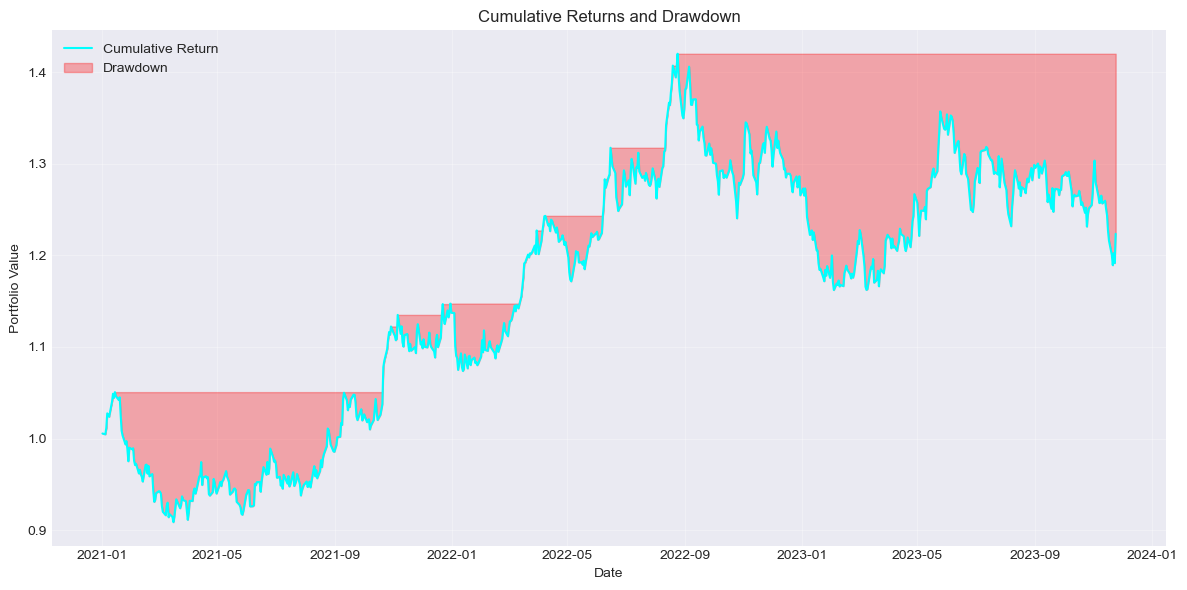

✅ PDF file saved: Strategy_Performance_Chart.pdf


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Simulated daily returns (replace this with your strategy's real returns)
np.random.seed(42)
daily_returns = np.random.normal(0.0005, 0.01, 252 * 3)  # 3 years of daily returns
dates = pd.date_range(start="2021-01-01", periods=len(daily_returns), freq='B')
returns_series = pd.Series(daily_returns, index=dates, name="Daily Return")

# ---- 1. Calculate Sharpe Ratio ----
risk_free_rate = 0.01
trading_days = 252
excess_returns = returns_series - (risk_free_rate / trading_days)
sharpe_ratio = (excess_returns.mean() / excess_returns.std()) * np.sqrt(trading_days)

# ---- 2. Calculate Max Drawdown ----
cumulative_returns = (1 + returns_series).cumprod()
rolling_max = cumulative_returns.cummax()
drawdown = (cumulative_returns - rolling_max) / rolling_max
max_drawdown = drawdown.min()

# ---- 3. Save performance metrics to CSV ----
performance_df = pd.DataFrame({
    "Sharpe Ratio": [sharpe_ratio],
    "Max Drawdown (%)": [max_drawdown * 100]
})
performance_df.to_csv("Strategy_Performance_Metrics.csv", index=False)
print("✅ CSV file saved: Strategy_Performance_Metrics.csv")

# ---- 4. Save cumulative return chart as PDF ----
print(plt.style.available)
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns.index, cumulative_returns, label='Cumulative Return', color='cyan')
plt.fill_between(cumulative_returns.index, cumulative_returns, rolling_max, color='red', alpha=0.3, label='Drawdown')
plt.title("Cumulative Returns and Drawdown")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("Strategy_Performance_Chart.pdf")
plt.show()
print("✅ PDF file saved: Strategy_Performance_Chart.pdf")